## Uniswap V2 Simple Tree (Part 1)

- Assumptions:
    - Uses Simple Tree
    - Uses stablecoins (ie, USDC and USDT) to control for impermanent loss
    - Infinite index token supply

- LPs include:
    - USDC-USDT
    - USDC-iUSDC
 
* [Medium Article: Liquidity Tree Performance using Stablecoins: Part 1](https://medium.com/datadriveninvestor/liquidity-tree-performance-using-stablecoins-part-1-ee09eae2fb86)

In [13]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats 
import statsmodels.api as sm
import seaborn as sns

from uniswappy import *
cwd =  os.getcwd().replace("notebooks/medium_articles","")
os.chdir(cwd)

### Script params

In [14]:
init_tkn_lp = 100000
tkn_delta_param = 1000
tkn_invest_amt = 100
tkn_nm = 'USDC'
itkn_nm = 'iUSDC'
usdt_nm = 'USDT'
iusdt_nm = 'iUSDT'

### Simulate price data

Text(0.5, 0, 'Date')

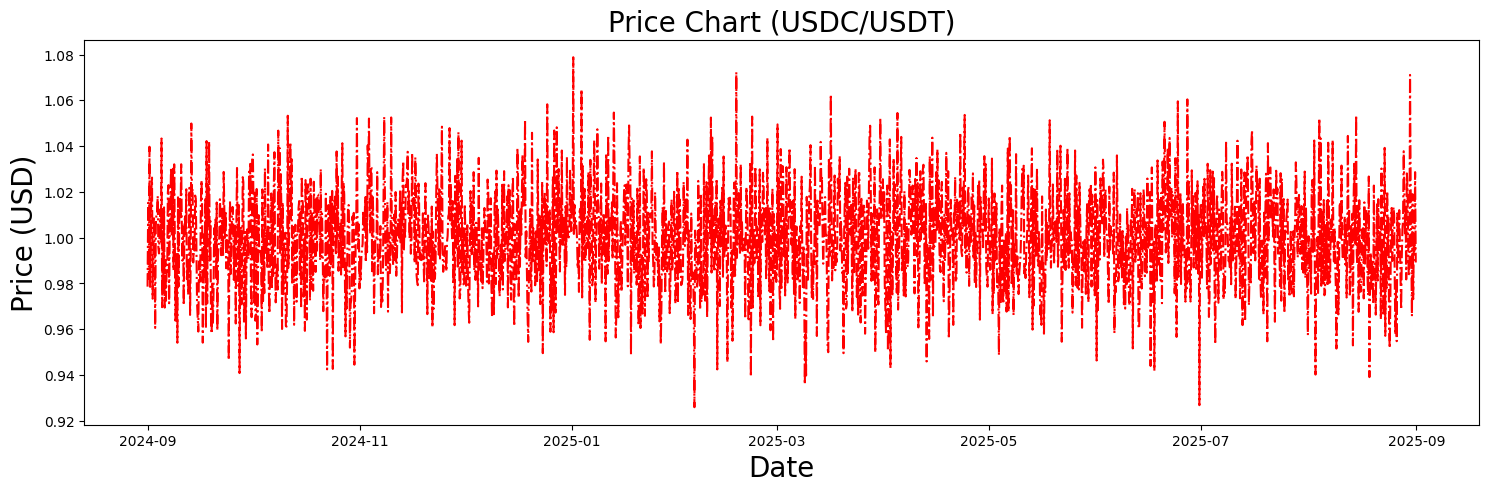

In [15]:
# *************************
# *** Simulation
# *************************
n_sim_runs = 2000
seconds_year = 31536000
shape = 2000
scale = 0.0005

p_arr = np.random.gamma(shape = shape, scale = scale, size = n_sim_runs)

n_runs = len(p_arr)-1    
dt = datetime.timedelta(seconds=seconds_year/n_sim_runs)
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_sim_runs)]   

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_title(f'Price Chart ({tkn_nm}/{usdt_nm})', fontsize=20)
USD_ax.set_ylabel('Price (USD)', size=20)
USD_ax.set_xlabel('Date', size=20)

### Initialization Params

In [16]:
user_nm = 'user0'
tkn_amount = init_tkn_lp 
usdt_amount = p_arr[0]*tkn_amount 

### Initialize Simple DEX Tree

In [17]:
usdt1 = ERC20(usdt_nm, "0x111")
tkn1 = ERC20(tkn_nm, "0x09")
exchg_data = UniswapExchangeData(tkn0 = tkn1, tkn1 = usdt1, symbol="LP", address="0x011")

TKN_amt = TokenDeltaModel(tkn_delta_param)

iVault1 = IndexVault('iVault1', "0x7")
factory = UniswapFactory(f"{tkn_nm} pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, tkn_amount, usdt_amount)

tkn2 = ERC20(tkn_nm, "0x09")
itkn1 = IndexERC20(itkn_nm, "0x09", tkn1, lp)
exchg_data1 = UniswapExchangeData(tkn0 = tkn2, tkn1 = itkn1, symbol="LP1", address="0x012")
lp1 = factory.deploy(exchg_data1)
JoinTree().apply(lp1, user_nm, iVault1, 10000)

# Re-balance LP price after JoinTree
SwapDeposit().apply(lp, usdt1, user_nm, lp.get_reserve(tkn1) - lp.get_reserve(usdt1))

lp.summary()
lp1.summary()

Exchange USDC-USDT (LP)
Reserves: USDC = 110000.0, USDT = 110000.0
Liquidity: 109982.92507448512 

Exchange USDC-iUSDC (LP1)
Reserves: USDC = 9972.071706380653, iUSDC = 4821.097443238953
Liquidity: 6933.709642567049 



#### Take an investment position

In [18]:
tkn_invest = 100
invested_user_nm = 'invested_user'

SwapIndexMint(iVault1, opposing = False).apply(lp, tkn1, invested_user_nm, tkn_invest)
mint_itkn1_deposit = lp1.convert_to_human(iVault1.index_tokens[itkn_nm]['last_lp_deposit'])
SwapDeposit().apply(lp1, itkn1, invested_user_nm, mint_itkn1_deposit)

lp.summary()
lp1.summary()

lp_invest_track  = lp.get_liquidity_from_provider(invested_user_nm)
lp1_invest_track  = lp1.get_liquidity_from_provider(invested_user_nm)

# Redeem from parent
tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)

# Redeem from tree (child + parent)
itkn_redeem_child = LPQuote(False).get_amount_from_lp(lp1, itkn1, lp1_invest_track)
tkn_redeem_tree = LPQuote(False).get_amount_from_lp(lp, tkn1, itkn_redeem_child) 

print(f'{tkn_redeem_parent:.3f} USDC redeemed from {lp_invest_track:.3f} LP tokens if {tkn_invest:.1f} invested USDC immediately pulled from parent')
print(f'{tkn_redeem_tree:.3f} USDC redeemed from {lp1_invest_track:.3f} LP1 tokens if {tkn_invest:.1f} invested USDC immediately pulled from tree')

Exchange USDC-USDT (LP)
Reserves: USDC = 110100.0, USDT = 110000.0
Liquidity: 110032.83087252118 

Exchange USDC-iUSDC (LP1)
Reserves: USDC = 9972.071706380653, iUSDC = 4871.003241275021
Liquidity: 6969.450772282173 

99.700 USDC redeemed from 49.906 LP tokens if 100.0 invested USDC immediately pulled from parent
99.403 USDC redeemed from 35.741 LP1 tokens if 100.0 invested USDC immediately pulled from tree


#### Simulate trading

In [19]:
arb = CorrectReserves(lp, x0 = 1)
arb1 = CorrectReserves(lp1, x0 = lp1.reserve1/lp1.reserve0)

TKN_amt = TokenDeltaModel(n_sim_runs)

lp_direct_invest_arr = []; lp1_direct_invest_arr = []; lp1_tree_invest_arr = []; 
pTKN_USDT_arr = []; pTKN_iTKN_arr = []
fee_lp_arr  = []; fee_lp1_arr  = [];

for k in range(n_sim_runs):

    # *****************************
    # ***** Parent Arbitrage ******
    # *****************************   
    arb.apply(p_arr[k])

    # *****************************
    # ***** Child Arbitrage ******
    # *****************************       
    #p_lp1 = SettlementLPToken().apply(lp, tkn1, lp1.reserve0)/lp1.reserve0
    p_lp1 = LPQuote().get_lp_from_amount(lp, tkn1, lp1.get_reserve(tkn2))/lp1.get_reserve(tkn2)
    arb1.apply(p_lp1)

    # *****************************
    # ***** Random Swapping ******
    # *****************************       
    Swap().apply(lp, tkn1, user_nm, TKN_amt.delta()) 
    Swap().apply(lp, usdt1, user_nm, TKN_amt.delta()) 

    # conservatively assume 20% of parent trading by volume
    Swap().apply(lp1, tkn2, user_nm, 0.2*TKN_amt.delta()) 
    #Swap().apply(lp1, itkn1, user_nm, SettlementLPToken().apply(lp, tkn1, 0.2*TKN_amt.delta()))
    Swap().apply(lp1, itkn1, user_nm, LPQuote().get_lp_from_amount(lp, tkn1, 0.2*TKN_amt.delta()))

    # *****************************
    # ******* Data Capture ********
    # *****************************

    # price
    pTKN_USDT_arr.append(LPQuote().get_price(lp, tkn1)) 
    pTKN_iTKN_arr.append(LPQuote().get_price(lp1, tkn1)) 

    # investment performance
    tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)
    itkn_redeem_child = LPQuote(False).get_amount_from_lp(lp1, itkn1, lp1_invest_track)    
    tkn_redeem_tree = LPQuote(False).get_amount_from_lp(lp, tkn1, itkn_redeem_child)     

    lp_direct_invest_arr.append(tkn_redeem_parent)
    lp1_direct_invest_arr.append(RebaseIndexToken().apply(lp1, tkn2, lp1_invest_track))    
    lp1_tree_invest_arr.append(tkn_redeem_tree)

    # DEX Fees         
    fee_lp_arr.append(TreeAmountQuote().get_tot_y(lp, lp.get_fee(tkn1), lp.get_fee(usdt1)))
    fee_lp1_arr.append(TreeAmountQuote().get_tot_y(lp1, lp1.get_fee(tkn2), lp1.get_fee(itkn1)))

lp.summary()
lp1.summary()

# Redeem from parent
tkn_redeem_parent = LPQuote(False).get_amount_from_lp(lp, tkn1, lp_invest_track)

# Redeem from tree (child + parent)
itkn_redeem_child = LPQuote(False).get_amount_from_lp(lp1, itkn1, lp1_invest_track) 
tkn_redeem_tree = LPQuote(False).get_amount_from_lp(lp, tkn1, itkn_redeem_child) 

print(f'{tkn_redeem_parent:.3f} USDC redeemed from {lp_invest_track:.3f} LP tokens if {tkn_invest:.1f} invested USDC pulled from parent (lp)')
print(f'{tkn_redeem_tree:.3f} USDC redeemed from {lp1_invest_track:.3f} LP1 tokens if {tkn_invest:.1f} invested USDC pulled from tree (lp + lp1)')

Exchange USDC-USDT (LP)
Reserves: USDC = 144977.92024428473, USDT = 145884.85966403352
Liquidity: 137208.22779333178 

Exchange USDC-iUSDC (LP1)
Reserves: USDC = 14187.000666283684, iUSDC = 5551.167129918616
Liquidity: 8048.506787579116 

105.286 USDC redeemed from 49.906 LP tokens if 100.0 invested USDC pulled from parent (lp)
103.628 USDC redeemed from 35.741 LP1 tokens if 100.0 invested USDC pulled from tree (lp + lp1)


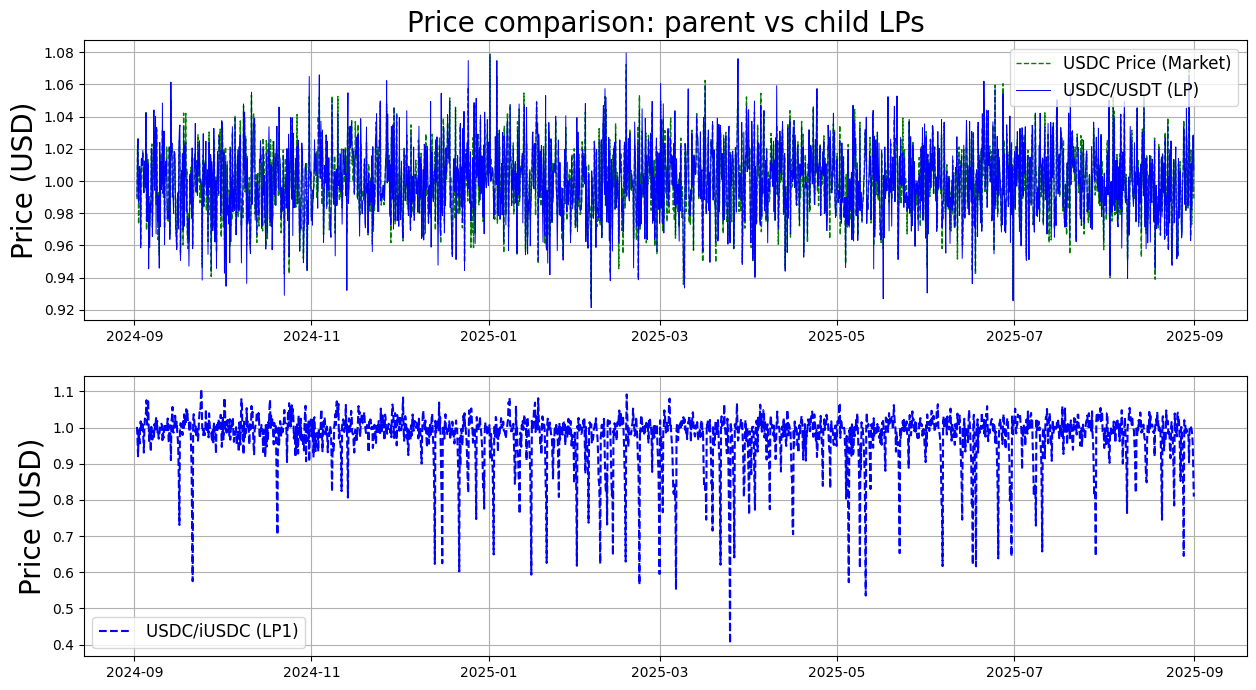

In [20]:
fig, (TKN_ax, USDT_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(15, 8))

strt_pt = 5

TKN_ax.plot(dates[strt_pt:], p_arr[strt_pt:], color = 'g',linestyle = 'dashed', linewidth=1, label=f'{tkn_nm} Price (Market)') 
TKN_ax.plot(dates[strt_pt:], pTKN_USDT_arr[strt_pt:], color = 'b',linestyle = '-', linewidth=0.7, label=f'{tkn_nm}/{usdt_nm} (LP)') 

TKN_ax.set_title('Price comparison: parent vs child LPs', fontsize=20)
TKN_ax.set_ylabel('Price (USD)', size=20)
TKN_ax.legend(fontsize=12)
TKN_ax.grid()

USDT_ax.plot(dates[strt_pt:], pTKN_iTKN_arr[strt_pt:], color = 'b',linestyle = 'dashed', label=f'{tkn_nm}/{itkn_nm} (LP1)') 
USDT_ax.set_ylabel('prices', size=20)
USDT_ax.set_ylabel('Price (USD)', size=20)
USDT_ax.legend(fontsize=12)
USDT_ax.grid()

Text(0, 0.5, 'Frequency')

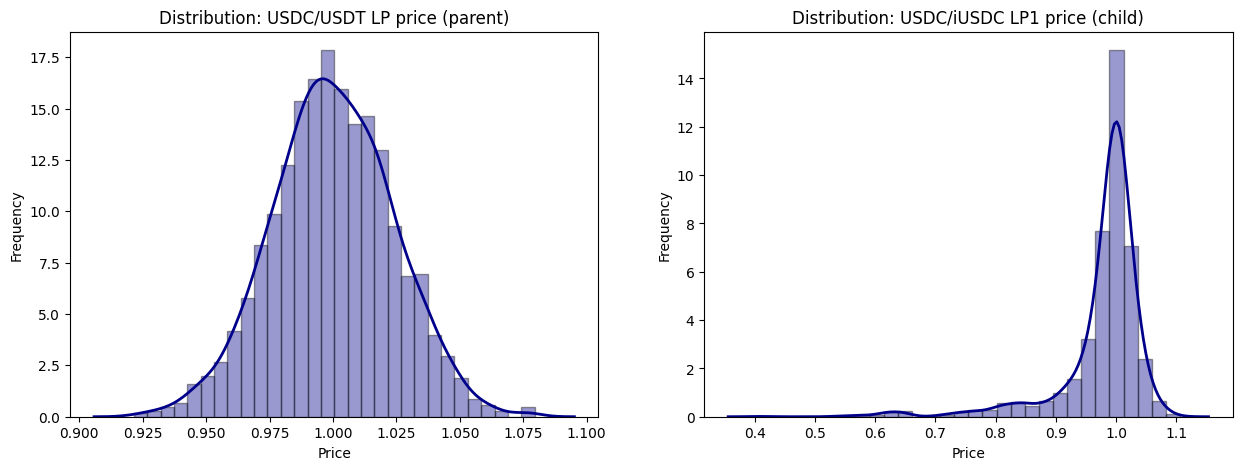

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(pTKN_USDT_arr, hist=True, kde=True, bins=int(30), color = 'darkblue',
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, ax=ax[0])

sns.distplot(pTKN_iTKN_arr, hist=True, kde=True, bins=int(30), color = 'darkblue',
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, ax=ax[1])

ax[0].set_title(f'Distribution: {tkn_nm}/{usdt_nm} LP price (parent)')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')

ax[1].set_title(f'Distribution: {tkn_nm}/{itkn_nm} LP1 price (child)')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency')

Text(0, 0.5, '$100 USD Investment')

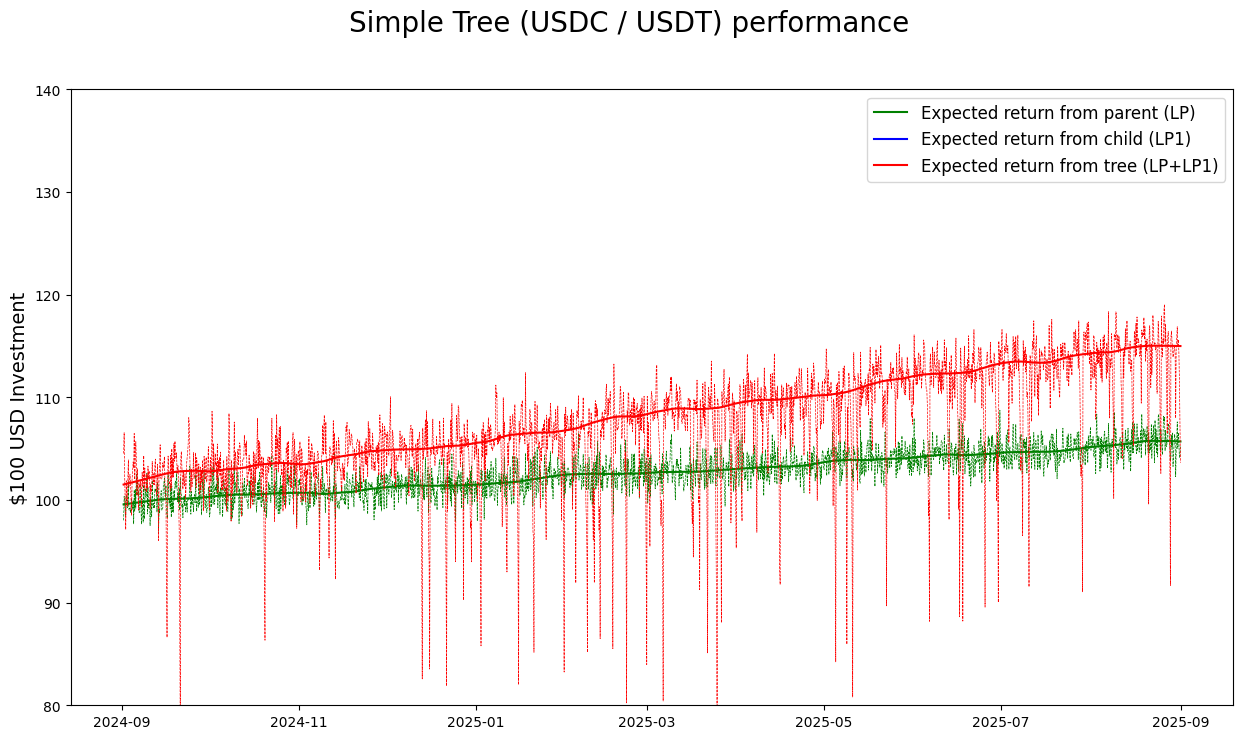

In [22]:
lowess = sm.nonparametric.lowess
x = range(0,n_sim_runs)
res = lowess(lp_direct_invest_arr, x, frac=1/15); sm_lp_direct = res[:,1]
res = lowess(lp1_direct_invest_arr, x, frac=1/15); sm_lp1_direct = res[:,1]
res = lowess(lp1_tree_invest_arr, x, frac=1/15); sm_lp1_tree= res[:,1]

strt_ind = 3

fig, (p_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(15, 8))
fig.suptitle('Simple Tree (USDC / USDT) performance ', fontsize=20)
p_ax.plot(dates[strt_ind:], lp_direct_invest_arr[strt_ind:], linestyle='dashed', linewidth=0.5, color = 'g') 
p_ax.plot(dates[strt_ind:], sm_lp_direct[strt_ind:], color = 'g', label = 'Expected return from parent (LP)') 
p_ax.plot(dates[strt_ind:], lp1_direct_invest_arr[strt_ind:], linestyle='dashed', linewidth=0.5, color = 'b')
p_ax.plot(dates[strt_ind:], sm_lp1_direct[strt_ind:], color = 'b', label = 'Expected return from child (LP1)') 
p_ax.plot(dates[strt_ind:], lp1_tree_invest_arr[strt_ind:], linestyle='dashed', linewidth=0.5, color = 'r')
p_ax.plot(dates[strt_ind:], sm_lp1_tree[strt_ind:], color = 'r', label = 'Expected return from tree (LP+LP1)') 
p_ax.legend( fontsize=12)
p_ax.set_ylim(80, 140) 
p_ax.set_ylabel("$100 USD Investment", fontsize=14)

In [23]:
print(f'{tkn_invest:.3f} TKN before is worth {sm_lp_direct[-1]:.3f} TKN after direct investment into parent (lp)') 
print(f'{tkn_invest:.3f} TKN before is worth {sm_lp1_direct[-1]:.3f} TKN after direct investment into child (lp1)') 
print(f'{tkn_invest:.3f} TKN before is worth {sm_lp1_tree[-1]:.3f} TKN after investment into simple tree (lp + lp1)')

100.000 TKN before is worth 105.698 TKN after direct investment into parent (lp)
100.000 TKN before is worth 113922806590603329536.000 TKN after direct investment into child (lp1)
100.000 TKN before is worth 114.991 TKN after investment into simple tree (lp + lp1)


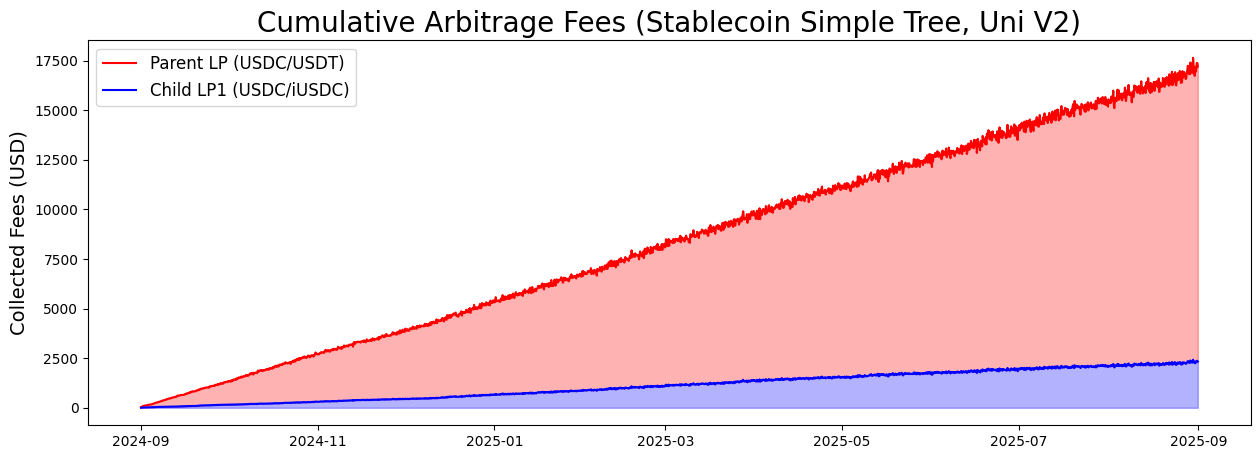

In [24]:
t = np.arange(0,len(fee_lp_arr))

fee_lpB = np.array(fee_lp1_arr)
fee_lpA = fee_lpB+np.array(fee_lp_arr)

fig = plt.figure(figsize=(15, 5))

plt.plot(dates, fee_lpA, color = 'r', label = f'Parent LP ({tkn_nm}/{usdt_nm})')
plt.fill_between(dates, fee_lpB, fee_lpA, alpha=0.3, color='r')

plt.plot(dates, fee_lpB, color = 'b', label = f'Child LP1 ({tkn_nm}/{itkn_nm})') 
plt.fill_between(dates, np.repeat(0,len(fee_lp_arr)), fee_lpB, alpha=0.3, color='b')

plt.title('Cumulative Arbitrage Fees (Stablecoin Simple Tree, Uni V2)', fontsize = 20)
plt.ylabel("Collected Fees (USD)", fontsize=14) 

plt.legend(fontsize=12)